In [1]:
%matplotlib inline

In [2]:
#import gym modules
import gym

In [3]:
# import pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

from torch.autograd import Variable

In [4]:
# import time to slow down rendering speed
import time
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from itertools import count

In [101]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


In [6]:
# create gym env
env = gym.make('BreakoutDeterministic-v4')

In [7]:
# reset it to return to the starting frame
frame = env.reset()

# render
# uncomment in an environment that can render frames
# env.render()

# loop until done
# random agent
is_done = False
while not is_done:
    # Perform random action, return new frame, reward and whether the game is completed
    frame, reward, is_done, _ = env.step(env.action_space.sample())

    # render next frame
    # uncomment in an environment that can render frames
    # env.render()

    # time.sleep()

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [93]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(2240, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
#         print("1", x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
#         print("2", x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
#         print("3", x.shape)
#         xx = x.view(1, -1)
#         print("final", x.shape)
#         print(xx.shape)
        return self.head(x.view(x.size(0), -1))

In [116]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(5000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
#         print("not random")
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
#         print("random")
        return LongTensor([[random.randrange(2)]])


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())


In [117]:
last_sync = 0


def optimize_model():
    global last_sync
    
    # if population of the replay memory is not enough, don't do anything
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [118]:
params = list(model.parameters())

In [119]:
def to_grayscale(img):
    """
    turns an image into a grayscale image
    """
    return np.mean(img, axis=2).astype(np.uint8)

In [120]:
def downsample(img):
    """
    downsamples an image by taking everyone second pixel
    """
    return img[::2, ::2]

In [121]:
def preprocess(img):
    """
    preprocesses the image with grayscale and downsampling
    """
    return to_grayscale(downsample(img))

In [122]:
def transform_reward(reward):
    """
    returns the sign of the reward, so that the learning agent can be used in multiple games
    """
    return np.sign(reward)

In [123]:
from PIL import Image
resize = T.Compose([T.ToPILImage(),
                    T.ToTensor()])

def get_screen(frame):
#     frame = torch.from_numpy(preprocess(frame)).unsqueeze(0)
    screen = preprocess(frame)
#     screen = frame.transpose(
#         (2, 0, 1))  # transpose into torch order (CHW)
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen).unsqueeze(0)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

Running episode #1; episode duration is 129 steps


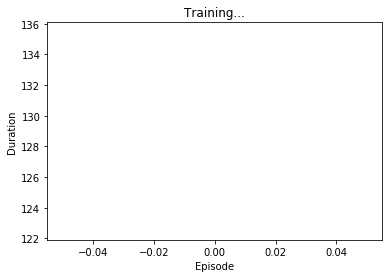

Running episode #11; episode duration is 139 steps


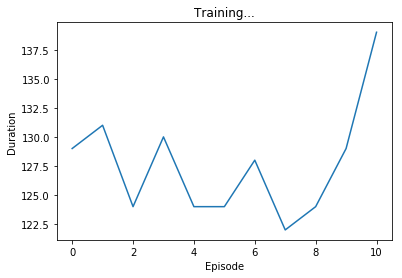

Running episode #21; episode duration is 125 steps


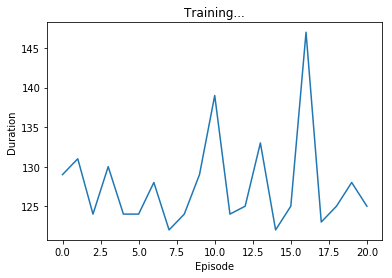

Running episode #31; episode duration is 126 steps


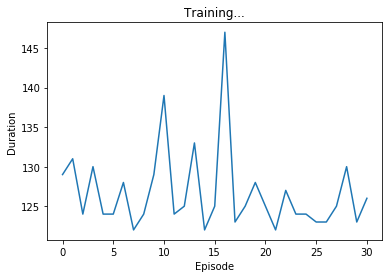

Running episode #41; episode duration is 124 steps


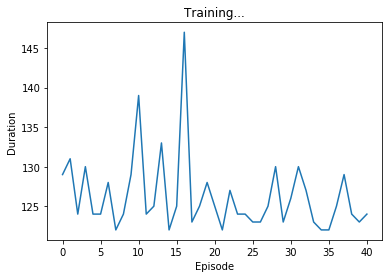

Running episode #51; episode duration is 136 steps


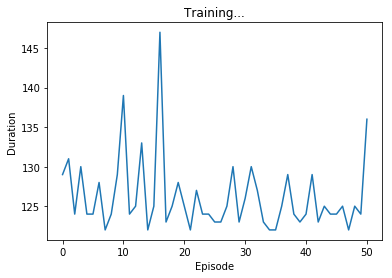

Running episode #61; episode duration is 124 steps


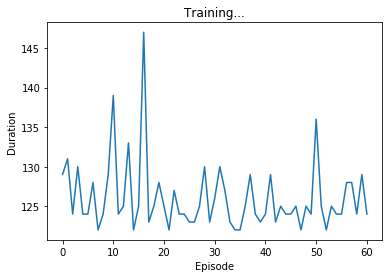

Running episode #71; episode duration is 123 steps


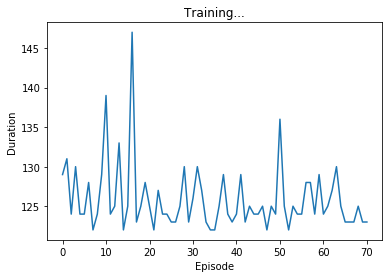

Running episode #81; episode duration is 127 steps


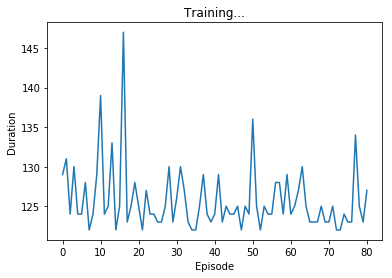

Running episode #91; episode duration is 123 steps


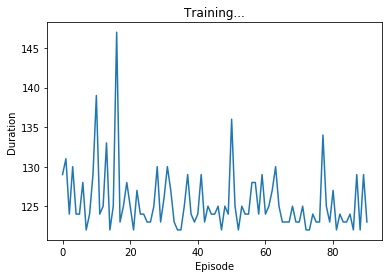

Running episode #101; episode duration is 129 steps


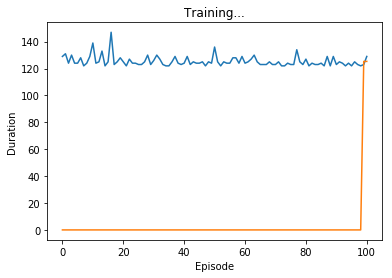

Running episode #111; episode duration is 127 steps


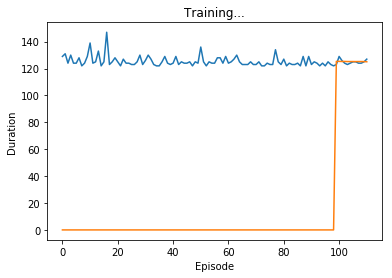

In [ ]:
# main
plot_every = 10
print_every = 10
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    # get initial observation
    init_obs = env.reset()
    current_screen = get_screen(init_obs)
    state = current_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_obs, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])
        

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen(next_obs)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            if i_episode % print_every == 0:
                print("Running episode #%d; episode duration is %d steps" % (len(episode_durations), t+1))
            if i_episode % plot_every == 0:
                plot_durations()
            break

print('Complete')
